In [58]:
# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import os
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import math
from torchvision import models, datasets # For pre-trained models (for transfer learning)
import joblib


In [59]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


## Hyperparameter List

In [ ]:
TARRGET_SIZE = (224, 224) # what size we want to reshape to for data augmentation (see below)
BATCH_SIZE = 32

should_train_custom_model = False # Load existing model from file if False
should_train_resnet_model = False # Load existing model from file if False


# test commit

## Data Exploration, Visualization, Pre-Processing



In [61]:
def load_dataset_dataframes():
  test_array = []
  train_array = []

  for category in os.listdir('Testing'):
    for file in os.listdir(os.path.join('Testing', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Testing', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          test_array.append([file_path, category])

  test_dataframe = pd.DataFrame(test_array, columns=['file_path', 'label'])

  for category in os.listdir('Training'):
    for file in os.listdir(os.path.join('Training', category)):
        # Ensure we're only adding image files
        file_path = os.path.join('Training', category, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
          train_array.append([file_path, category])

  train_dataframe = pd.DataFrame(train_array, columns=['file_path', 'label'])

  return test_dataframe, train_dataframe

def load_image(image_path):
  image = Image.open(image_path)
  image = image.resize((64, 64))
  image = np.array(image)
  image = torch.from_numpy(image).float()
  return image

### Exploring the Data

In [62]:
# Display a couple random samples (re-run to load a new image)
test_dataframe, train_dataframe = load_dataset_dataframes()


random_image_path = np.random.choice(test_dataframe['file_path'])
random_image = load_image(random_image_path)
display(random_image_path)
px.imshow(random_image, color_continuous_scale='gray').show()

'Testing\\notumor\\Te-no_0208.jpg'

In [63]:
# Plot the dataset
def plot_dataset(dataset_type):

    base_directory = os.getcwd()
    categories = os.listdir(base_directory+'/'+dataset_type)

    path = os.path.join(base_directory, dataset_type)
    counts = [len(os.listdir(os.path.join(path, cat))) for cat in categories]

    plt.bar(categories, counts, color = ['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_type.capitalize()} Set Distribution")
    plt.show()


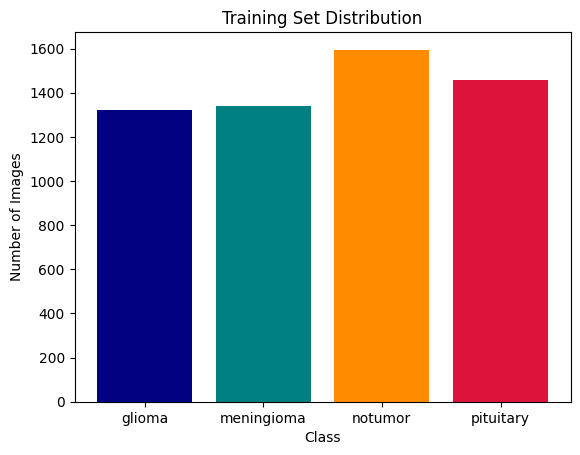

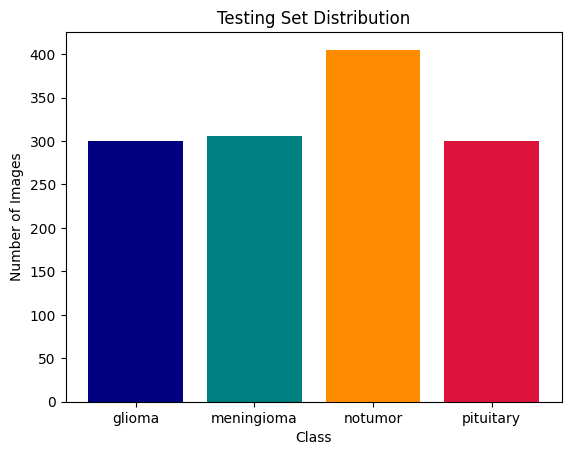

In [64]:
plot_dataset('Training')
plot_dataset('Testing')

### Data Preprocessing

In [65]:
# Important!!!! Turn categories into numbers for use within neural networks

label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

train_dataframe['label'] = train_dataframe['label'].map(label_map)
test_dataframe['label'] = test_dataframe['label'].map(label_map)

### Splitting into train, validation, and test sets

In [66]:
def split_test_validation(data, ratio=0.50):


    # shuffle before we do the split
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)


    # if the list isn't divisble by 50%...
    split_index_test = math.ceil(len(data) * ratio)


    test_df = data[:split_index_test]
    val_df = data[split_index_test:]

    return test_df, val_df





test_df_split, val_df_split = split_test_validation(test_dataframe, ratio=0.5)
# Reset indices for consistency (instead of index starting from halfway, it'll start from 0)
test_df_split = test_df_split.reset_index(drop=True)
val_df_split = val_df_split.reset_index(drop=True)


print(test_dataframe.size)
print(test_df_split.size)
print(val_df_split.size)

2622
1312
1310


In [67]:
# print out test and validation data frame, see if order is random
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [68]:
print(test_df_split)
print('\n\n\n\n\n\n----------------------------------------------\n\n\n\n\n')
print(val_df_split)

                             file_path  label
0     Testing\pituitary\Te-pi_0109.jpg      3
1     Testing\pituitary\Te-pi_0061.jpg      3
2        Testing\glioma\Te-gl_0198.jpg      1
3    Testing\meningioma\Te-me_0275.jpg      2
4    Testing\meningioma\Te-me_0031.jpg      2
..                                 ...    ...
651   Testing\pituitary\Te-pi_0253.jpg      3
652     Testing\notumor\Te-no_0149.jpg      0
653     Testing\notumor\Te-no_0233.jpg      0
654     Testing\notumor\Te-no_0187.jpg      0
655   Testing\pituitary\Te-pi_0293.jpg      3

[656 rows x 2 columns]






----------------------------------------------





                             file_path  label
0      Testing\glioma\Te-glTr_0007.jpg      1
1       Testing\notumor\Te-no_0060.jpg      0
2     Testing\pituitary\Te-pi_0063.jpg      3
3    Testing\meningioma\Te-me_0057.jpg      2
4    Testing\meningioma\Te-me_0029.jpg      2
..                                 ...    ...
650   Testing\pituitary\Te-pi_0084.jpg      

### Create Class ImageDataset
##### Inherits from Pytorch's "Dataset" class, can be used to load Data

In [69]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

### Data Augmentation

In [70]:
train_transform = transforms.Compose([

   transforms.Resize(TARRGET_SIZE),
   transforms.RandomHorizontalFlip(),
   transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
   transforms.ColorJitter(brightness=(0.8, 1.2)),
   transforms.RandomRotation(10),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [71]:
# Apply Data Augmentation

final_train_dataset = ImageDataset(train_dataframe, transform=train_transform)
final_val_dataset = ImageDataset(val_df_split, transform=test_transform)
final_test_dataset = ImageDataset(test_df_split, transform=test_transform)


# DataLoader

train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train and Test Functions (used by all models)

In [72]:
base_directory = os.getcwd()
categories = os.listdir(base_directory+'/Training')

In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, name='model', patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    tolerance = 0  # Counter for early stopping
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        print("#" * 80)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_brain_tumor_{name}.pth')
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    return history

In [79]:
def test_model(model, test_loader, num_images_to_show=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0
# Shufflte the data as the first thing we do

    all_preds = []
    all_labels = []
    all_images = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())  # Store images for visualization

    test_acc = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=categories))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Plots / Graphing Stuff

In [75]:
def plot_training_history(history, model_name="model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

In [76]:
def visualize_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_images, incorrect_images = [], []
    correct_labels, incorrect_labels = [], []
    correct_preds, incorrect_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Separate correct and incorrect predictions
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(images[i])
                    correct_labels.append(labels[i].cpu().item())
                    correct_preds.append(predicted[i].cpu().item())
                else:
                    incorrect_images.append(images[i])
                    incorrect_labels.append(labels[i].cpu().item())
                    incorrect_preds.append(predicted[i].cpu().item())

    # Visualization
    # Unnormalize using your mean and std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    num_cols = num_images // 2
    plt.figure(figsize=(15, 7))

    # Display correct predictions
    for i, img_tensor in enumerate(correct_images[:num_images // 2]):
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[correct_labels[i]]}\nPred: {categories[correct_preds[i]]}", color='green', fontsize=15)
        plt.axis('off')

    # Display incorrect predictions
    for i, img_tensor in enumerate(incorrect_images[:num_images // 2]):
        if i >= len(incorrect_images):
            plt.axis('off')
            continue
        img_tensor = img_tensor * std + mean  # reverse normalization
        img = np.clip(img_tensor.permute(1, 2, 0).cpu().numpy(), 0, 1)
        plt.subplot(2, num_cols, num_cols + i + 1)
        plt.imshow(img)
        plt.title(f"True: {categories[incorrect_labels[i]]}\nPred: {categories[incorrect_preds[i]]}", color='red', fontsize=15)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## (Model 1) Custom CNN

In [77]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> (B, 64, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # -> (B, 128, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 128, 28, 28)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # -> (B, 256, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> (B, 256, 14, 14)

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # -> (B, 256, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # -> (B, 256, 7, 7)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # -> (B, 256*7*7)
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  #Output layer for 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    
if should_train_custom_model:
    custom_model = CustomCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
    optimizer = optim.Adam(custom_model.parameters(), lr=0.0007)

    print("Starting training of custom CNN...")
    history_custom = train_model(custom_model, train_loader, val_loader, criterion, optimizer, num_epochs=40, name='custom_cnn')
    
    joblib.dump(custom_model, 'custom_cnn_model.pkl')
    joblib.dump(history_custom, 'custom_cnn_history.pkl')
else:
    custom_model = joblib.load('custom_cnn_model.pkl')
    history_custom = joblib.load('custom_cnn_history.pkl')


Starting training of custom CNN...
Epoch [1/40]
Train Loss: 0.9706, Train Accuracy: 58.07%
Val Loss: 0.6660, Val Accuracy: 73.89%
################################################################################
Epoch [2/40]
Train Loss: 0.6566, Train Accuracy: 72.39%
Val Loss: 0.6161, Val Accuracy: 75.11%
################################################################################
Epoch [3/40]
Train Loss: 0.5498, Train Accuracy: 78.19%
Val Loss: 0.4687, Val Accuracy: 82.14%
################################################################################
Epoch [4/40]
Train Loss: 0.4471, Train Accuracy: 83.11%
Val Loss: 0.4924, Val Accuracy: 79.69%
################################################################################
Epoch [5/40]
Train Loss: 0.3522, Train Accuracy: 86.78%
Val Loss: 0.3788, Val Accuracy: 86.41%
################################################################################
Epoch [6/40]
Train Loss: 0.2791, Train Accuracy: 89.93%
Val Loss: 0.2449, Val Accurac

Test Accuracy: 97.87%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99       192
  meningioma       0.99      0.96      0.97       151
     notumor       0.97      0.96      0.96       164
   pituitary       0.97      0.99      0.98       149

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



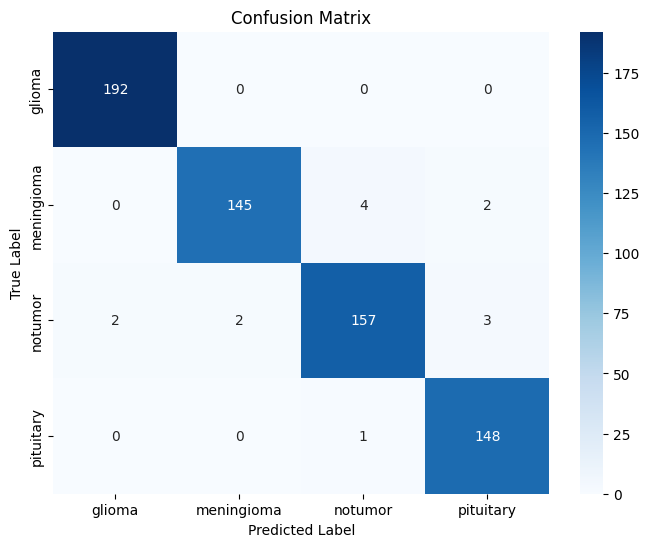

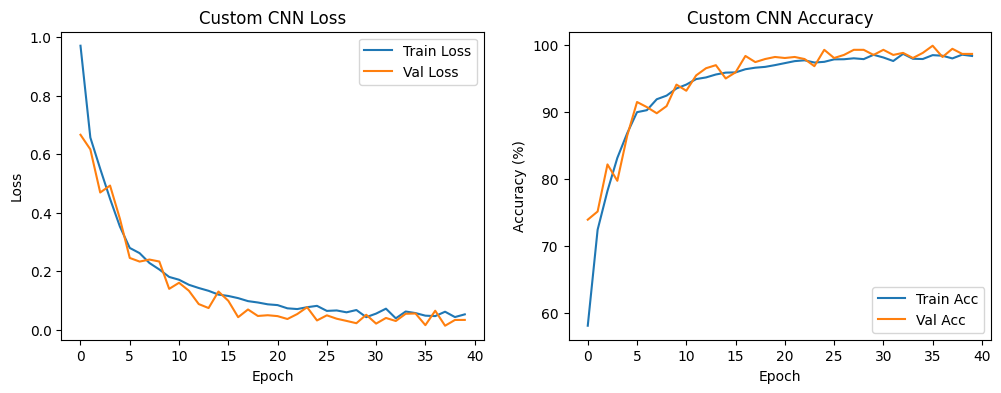

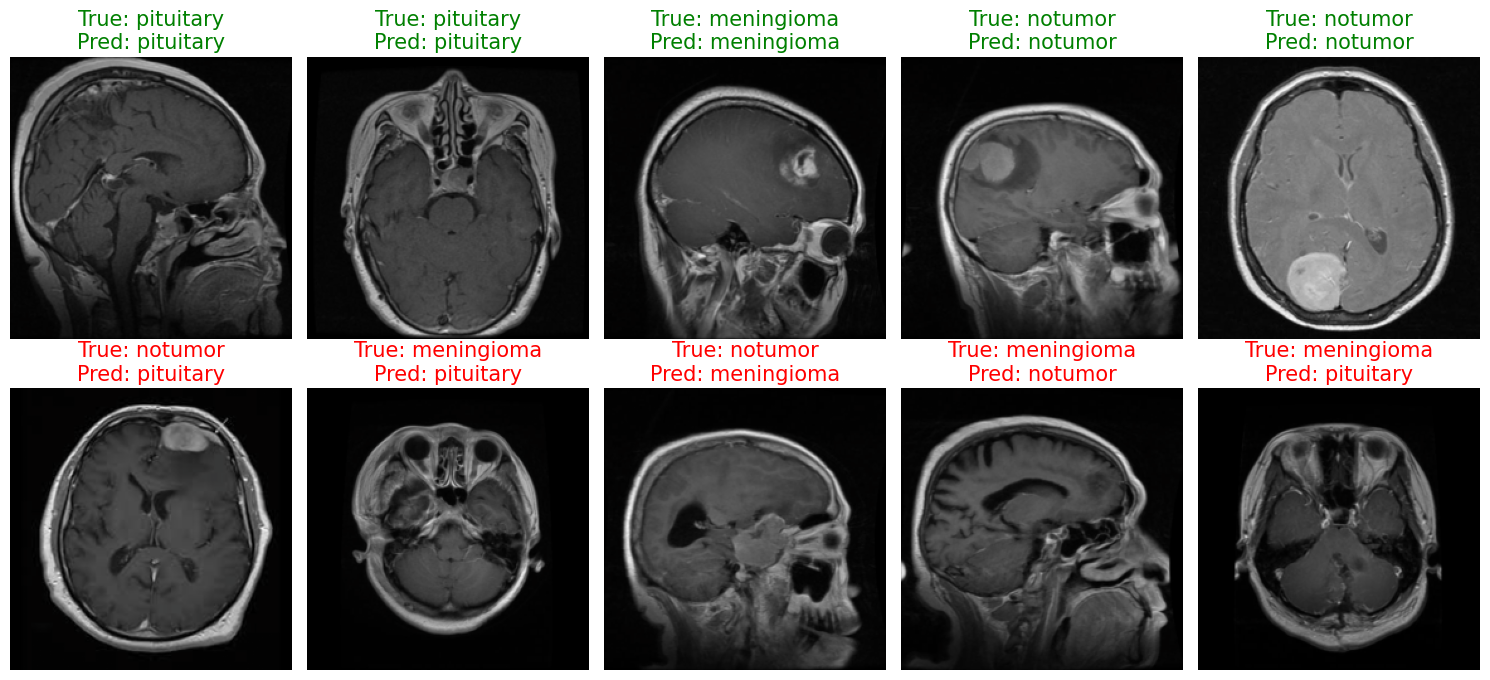

In [80]:
test_model(custom_model, test_loader)

plot_training_history(history_custom, model_name="Custom CNN")

visualize_predictions(custom_model, test_loader, num_images=10)


## (Model 2) ResNet

In [81]:
# Load pretrained ResNet-34 model
#transfer_model = models.resnet34(pretrained=True)
transfer_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)



In [82]:
# Freeze all layers except the final fully connected layer
for param in transfer_model.parameters():
    param.requires_grad = False

In [83]:
# use the "fc" field to get the FINAL fully connected layer in the model
num_ftrs = transfer_model.fc.in_features
transfer_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 4)
)

# Move model to device
transfer_model = transfer_model.to(device)

In [84]:
optimizer = optim.Adam(transfer_model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Train Model

In [86]:
print("Starting transfer learning training...")

if should_train_resnet_model:
    history = train_model(transfer_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='resnet18')
    joblib.dump(transfer_model, 'resnet18_model_unrefined.pkl')
    joblib.dump(history, 'resnet18_history_unrefined.pkl')
else:
    transfer_model = joblib.load('resnet18_model_unrefined.pkl')
    history = joblib.load('resnet18_history_unrefined.pkl')

Starting transfer learning training...
Epoch [1/30]
Train Loss: 0.2854, Train Accuracy: 89.58%
Val Loss: 0.2567, Val Accuracy: 89.92%
################################################################################
Epoch [2/30]
Train Loss: 0.2784, Train Accuracy: 89.34%
Val Loss: 0.2610, Val Accuracy: 89.77%
################################################################################
Epoch [3/30]
Train Loss: 0.2678, Train Accuracy: 89.72%
Val Loss: 0.3313, Val Accuracy: 87.48%
################################################################################
Epoch [4/30]
Train Loss: 0.2654, Train Accuracy: 89.69%
Val Loss: 0.3410, Val Accuracy: 86.41%
################################################################################
Epoch [5/30]
Train Loss: 0.2680, Train Accuracy: 89.86%
Val Loss: 0.2231, Val Accuracy: 91.15%
################################################################################
Epoch [6/30]
Train Loss: 0.2563, Train Accuracy: 90.06%
Val Loss: 0.3044, Val Acc

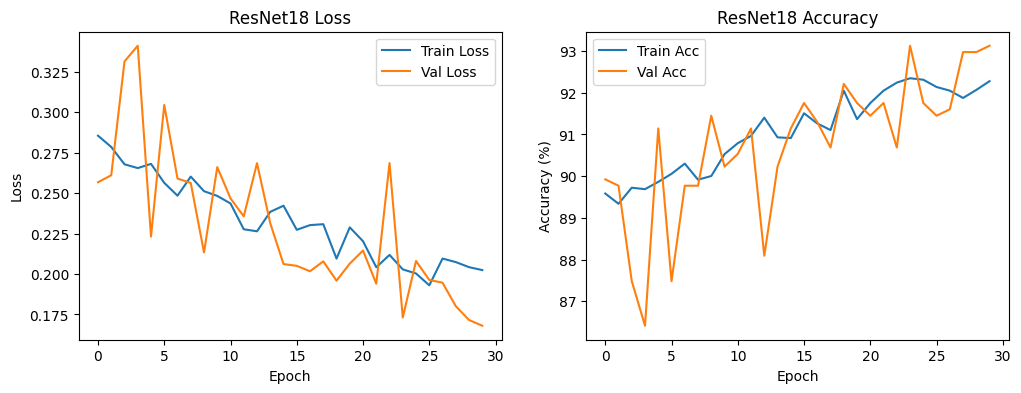

In [87]:
plot_training_history(history, model_name="ResNet18")


Loading best model for testing...
Test Accuracy: 91.46%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.99       192
  meningioma       0.98      0.74      0.85       151
     notumor       0.79      0.93      0.85       164
   pituitary       0.94      0.97      0.95       149

    accuracy                           0.91       656
   macro avg       0.92      0.91      0.91       656
weighted avg       0.92      0.91      0.91       656



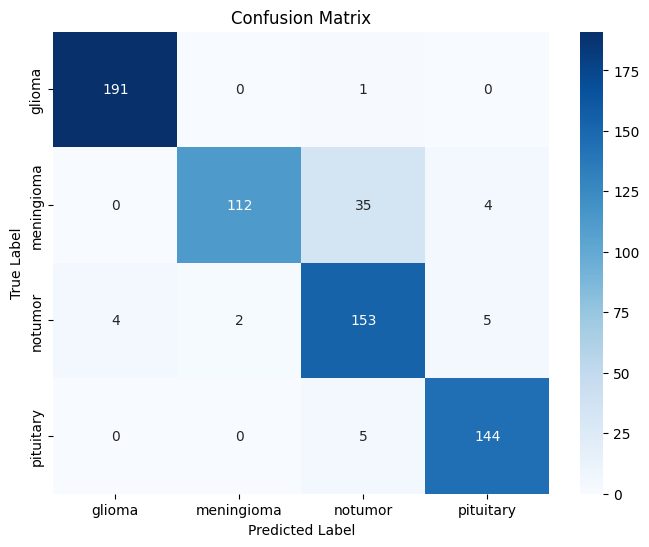

In [88]:
print("\nLoading best model for testing...")
transfer_model.load_state_dict(torch.load('best_brain_tumor_resnet18.pth'))
test_model(transfer_model, test_loader)

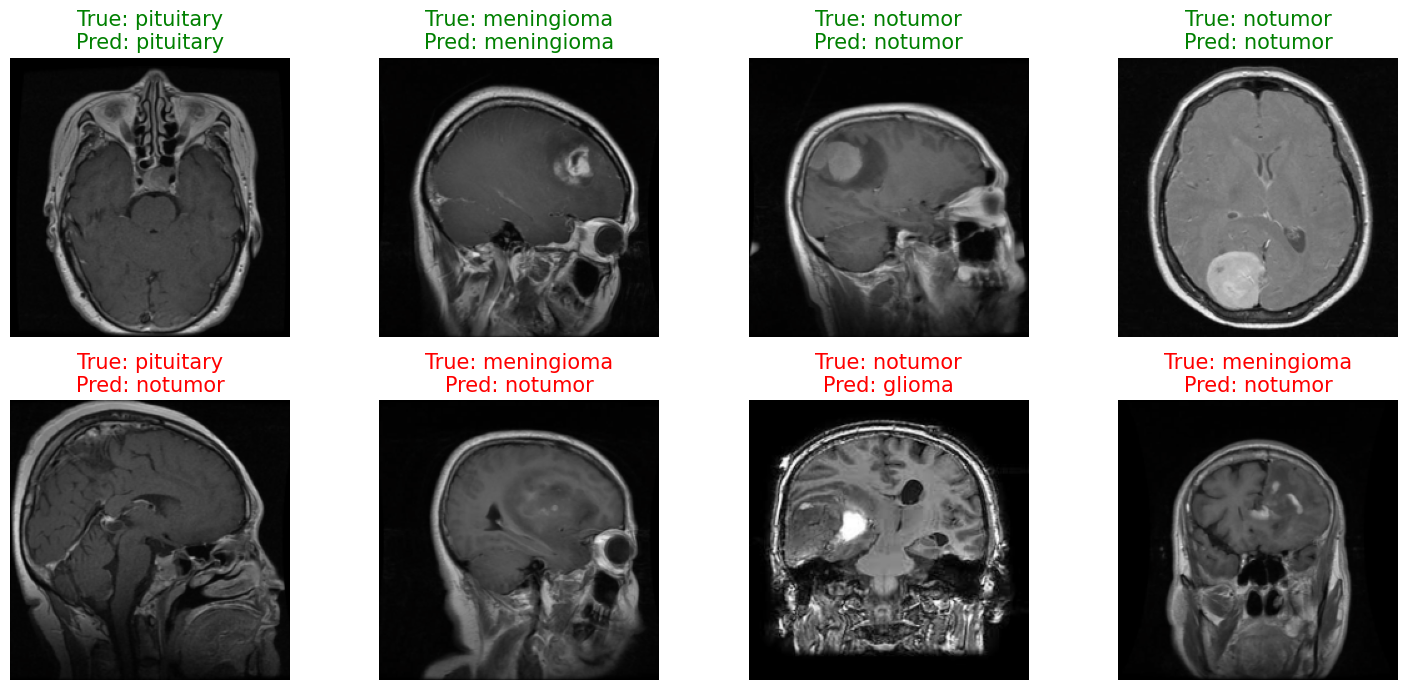

In [89]:
visualize_predictions(transfer_model, test_loader, 8)

Fine Tuning

In [90]:
# Unfreeze layer4, as well as the fully connected (fc) layer from the previous section

for name, param in transfer_model.named_parameters():
    if 'layer4' in name or 'layer3' in name or 'fc' in name:
        param.requires_grad = True

In [91]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.001) # 0.0001 is whats used


In [92]:
print("Starting training...")
if should_train_resnet_model:
    history = train_model(transfer_model, train_loader, val_loader, criterion, optimizer, num_epochs=30, name='resnet18_finetuned')
    joblib.dump(transfer_model, 'resnet18_model.pkl')
    joblib.dump(history, 'resnet18_history.pkl')
else:
    transfer_model = joblib.load('resnet18_model.pkl')
    history = joblib.load('resnet18_history.pkl')

Starting training...
Epoch [1/30]
Train Loss: 0.4755, Train Accuracy: 85.61%
Val Loss: 0.2633, Val Accuracy: 89.77%
################################################################################
Epoch [2/30]
Train Loss: 0.1898, Train Accuracy: 93.00%
Val Loss: 0.1538, Val Accuracy: 94.66%
################################################################################
Epoch [3/30]
Train Loss: 0.1574, Train Accuracy: 94.73%
Val Loss: 0.1949, Val Accuracy: 90.53%
################################################################################
Epoch [4/30]
Train Loss: 0.1435, Train Accuracy: 94.96%
Val Loss: 0.2572, Val Accuracy: 93.89%
################################################################################
Epoch [5/30]
Train Loss: 0.1264, Train Accuracy: 96.01%
Val Loss: 0.0710, Val Accuracy: 98.02%
################################################################################
Epoch [6/30]
Train Loss: 0.0984, Train Accuracy: 96.85%
Val Loss: 0.0602, Val Accuracy: 97.56%
####

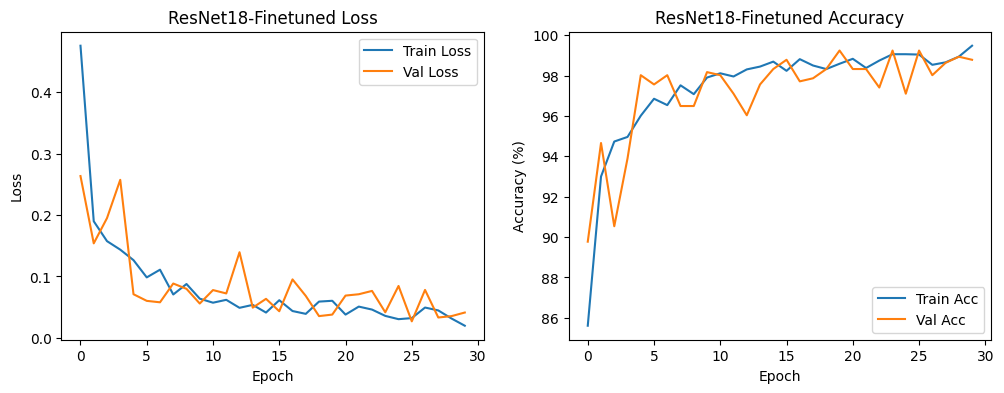

In [93]:
plot_training_history(history, model_name="ResNet18-Finetuned")


Loading best model for testing...
Test Accuracy: 98.02%

Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       192
  meningioma       1.00      0.94      0.97       151
     notumor       0.93      1.00      0.96       164
   pituitary       0.99      0.99      0.99       149

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



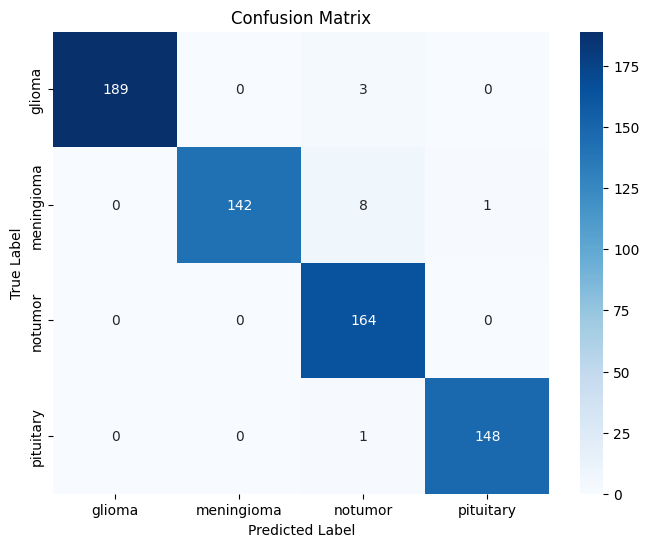

In [94]:
print("\nLoading best model for testing...")
transfer_model.load_state_dict(torch.load('best_brain_tumor_resnet18_finetuned.pth'))
test_model(transfer_model, test_loader)

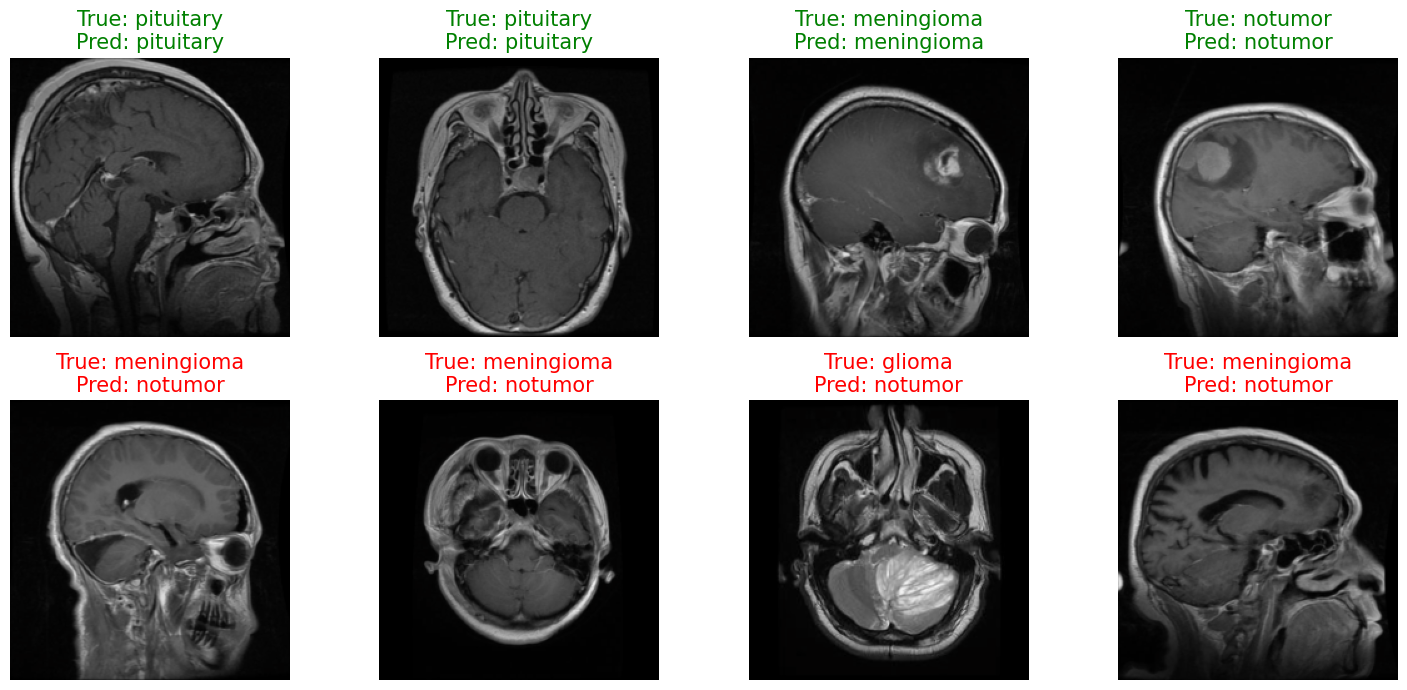

In [95]:
visualize_predictions(transfer_model, test_loader, 8)

## Gradient Visualization